In [1]:
from psf_constants import FC_PROCESSED_TRAIN_OUTPUT_FLUXES_PREFIX, \
                          FC_PROCESSED_TRAIN_COMPLEX_FIELDS_PREFIX, \
                          FC_PROCESSED_VALIDATION_OUTPUT_FLUXES_FILE_PATH, \
                          FC_PROCESSED_VALIDATION_COMPLEX_FIELDS_FILE_PATH

from data_utils import load_numpy_data


from modeling_utils import create_fully_connected_architecture_for_amplitude_and_phase_reconstruction, \
                           compile_model, \
                           train_model, \
                           train_model_with_generator, \
                           store_model

from configurations import SimpleFCModel as ModelConfig

2024-02-26 10:58:04.393154: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 10:58:04.439548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 10:58:04.439579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 10:58:04.440760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 10:58:04.448115: I tensorflow/core/platform/cpu_feature_guar

In [2]:
validation_fluxes_array = load_numpy_data(FC_PROCESSED_VALIDATION_OUTPUT_FLUXES_FILE_PATH)
validation_complex_fields_array = load_numpy_data(FC_PROCESSED_VALIDATION_COMPLEX_FIELDS_FILE_PATH)

In [3]:
validation_fluxes_array.shape

(10000, 19)

In [4]:
validation_complex_fields_array.shape

(10000, 32768)

In [5]:
model_configuration = ModelConfig()
print(model_configuration.get_description())


	=== PSF-FC-Reconstructor ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Fully Connected
		-Input shape: 19
		-Output shape: 32768
		-Hidden layers: [2000, 2000, 2000, 2000]
		-Regularizer: None
		-Hidden Layers Activation: relu
		-Output Layer Activation: linear
		-Batch Normalization: False
		-Dropout: False, 0.2
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	*TRAINING HYPERPARAMETERS:
		-Epochs: 200
		-Batch size: 64
		-Callbacks: 
			-ReduceLROnPlateau: MSE 10 x0.1
			-Early Stop: MSE 25
	


2024-02-26 10:58:07.824787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 10:58:07.937617: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 10:58:07.937985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
model = create_fully_connected_architecture_for_amplitude_and_phase_reconstruction(
    *model_configuration.unpack_architecture_hyperparameters()
)


Model: "PSF-FC-Reconstructor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              38000     
                                                                 
 activation (Activation)     (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 2000)              4000000   
                                                                 
 activation_1 (Activation)   (None, 2000)              0         
                                                                 
 dense_2 (Dense)             (None, 2000)              4000000   
                                                                 
 activation_2 (Activation)   (None, 2000)              0         
                                                                 
 dense_3 (Dense)             (None, 2000)     

In [7]:
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

In [8]:
history = train_model_with_generator(
    model,
    FC_PROCESSED_TRAIN_OUTPUT_FLUXES_PREFIX,
    FC_PROCESSED_TRAIN_COMPLEX_FIELDS_PREFIX,
    validation_fluxes_array,
    validation_complex_fields_array,
    *model_configuration.unpack_training_hyperparameters(),
    n_samples=20000
)

Epoch 1/200


2024-02-26 10:58:10.426693: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-26 10:58:11.260320: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa450e8d610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-26 10:58:11.260355: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-02-26 10:58:11.266976: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-26 10:58:11.288270: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1708905491.742104 1130606 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 [==============================] - 21s 57ms/step - loss: 1.0001 - mean_squared_error: 1.0001 - val_loss: 1.0000 - val_mean_squared_error: 1.0000 - lr: 0.0010
Epoch 2/200
313/313 [==============================] - 15s 47ms/step - loss: 1.0001 - mean_squared_error: 1.0001 - val_loss: 1.0001 - val_mean_squared_error: 1.0001 - lr: 0.0010
Epoch 3/200
313/313 [==============================] - 16s 51ms/step - loss: 1.0001 - mean_squared_error: 1.0001 - val_loss: 1.0000 - val_mean_squared_error: 1.0000 - lr: 0.0010
Epoch 4/200
313/313 [==============================] - 13s 43ms/step - loss: 1.0001 - mean_squared_error: 1.0001 - val_loss: 1.0000 - val_mean_squared_error: 1.0000 - lr: 0.0010
Epoch 5/200
313/313 [==============================] - 13s 43ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - val_loss: 1.0000 - val_mean_squared_error: 1.0000 - lr: 0.0010
Epoch 6/200
313/313 [==============================] - 13s 43ms/step - loss: 1.0000 - mean_squared_error: 1.0000 - val_los

In [9]:
from plot_utils import plot_model_history

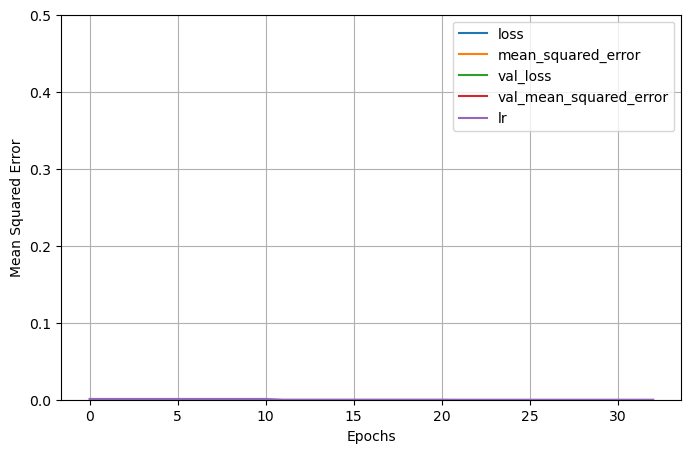

In [10]:
plot_model_history(history)